# 2. Odovzdanie - Predspracovanie
### Inteligentná analýza údajov
##### Martina Kolibášová, Tomáš Mizera

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn
import json
from pandas.io.json import json_normalize
from sklearn import linear_model as lm
import copy

from sklearn import linear_model as lm
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.base import TransformerMixin

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (8, 6)
from IPython.display import Image, SVG, display

In [2]:
data = pd.read_csv('./data/train.csv', index_col="Unnamed: 0")

#### Parsovanie atribútu medical_info (json)

In [3]:
data['medical_info'] = data['medical_info'].str.replace('\'', '\"')

In [4]:
lst = []

for a in data['medical_info']:
    record = json.loads(a)
    lst.append(record)
    
df = pd.DataFrame(lst)

data = pd.concat([data, df], axis=1)

Teraz ho treba ešte zmazať

In [5]:
data.drop(columns = ['medical_info'], axis=1, inplace = True)
default_data = copy.deepcopy(data)

### Zaujímavé doplnenia, background

V predspracovaní sme využili doplnenie chýbajúcich hodnôt aj pomocou KNN a lineárnej regresie.

 * __Lineárnu regresiu__ sme použili vďaka získaniu znalosti o atribútoch (čo predstavujú v medicíne). Atribút T3 a TT4 spolu korelujú, je to vďaka tomu, že oba sú to hormóny produkované zo štítnej žľazy. Majú vlastnosť, že hodnota jedného je prevoditeľná určitým vzťahom na hodnotu druhého, preto napríklad ak máme nameranú hodnotu TT4, nepotrebujeme poznať T3, vieme ju odvodiť. Tento vzťah bohužiaľ nepoznáme (závisí od viac vecí), no na základe toho, že vieme o tomto vzťahu, rozhodli sme sa použiť lineárnu regresiu, ktorá dokáže pekne simulovať tento prevod. (na grafoch pri spracovaní atribútu T3).
 * __KNN__ sme použili na predikovanie kategorických atribútov workclass a occupation. KNN sme vycvičili na základe poznaných atribútov hours-per-week, education-num a age, nakoľko sme si povedali, že povolanie môže najviac záležať od týchto atribútov.
 
 --------------

## Spracovanie jednotlivých atribútov 

Nasleduje predspracovanie jednotlivých atribútov s problémovými hodnotami. Atribúty, ktoré boli v poriadku tu neuvádzame.

## Attribute sex

Pohlavie si vieme určiť napríklad z toho že či je daná osoba tehotná keďže tehotná môže byť len žena. Źiaľ chýbajúce pohlavie a zároveň true v stĺpci pregnant máme len v jednom prípade 

In [6]:
class Abc(TransformerMixin):
    def __init__(self, column, source, target):
        self.column = column
        self.source = source
        self.target = target
        
    def fit(self, df, y=None, **fit_params):
        return self
    
    def transform(self, df, **transform_params):
        sample = df[self.column] == self.source
        df.loc[sample, self.column] = self.target
        return df

In [7]:
ppl = Pipeline([
              ('name1', Abc('sex', 'F', 'Female')),
            ('name2', Abc('sex', 'M', 'Male')),
           
      ])

model = ppl.fit(data)
model.transform(data)
data['sex'].unique()

array(['Male', 'Female', '?'], dtype=object)

In [8]:
data[(data['sex'].isna())&(data['pregnant'] == True)]

,age,sex,on antithyroid medication,sick,query hyperthyroid,lithium,goitre,tumor,hypopituitary,TSH,...,I131 treatment,T3 measured,T4U measured,TSH measured,on thyroxine,pregnant,psych,query hypothyroid,query on thyroxine,thyroid surgery


In [9]:
data.loc[291,'sex'] = 'Female'
data.loc[291,'sex'] 

'Female'

#### Tu si vieme pomôcť a nahradiť v celom dataframe hodnoty ako "f", "FALSE", " ?" a podobné, zodpovedajúcimi hodnotami False, True, príp. np.nan

In [10]:
data.replace(['f','F','FALSE','false','t','true','TRUE','T','?', ' ?','??','nan'], [False,False, False,False,True,True,True,True,np.nan, np.nan, np.nan, np.nan], inplace = True)

In [11]:
data['sex'].fillna('Unknown sex', inplace = True)
data.head(10)

,age,sex,on antithyroid medication,sick,query hyperthyroid,lithium,goitre,tumor,hypopituitary,TSH,...,I131 treatment,T3 measured,T4U measured,TSH measured,on thyroxine,pregnant,psych,query hypothyroid,query on thyroxine,thyroid surgery
0,51.0,Male,False,False,False,False,False,False,False,1.40,...,False,True,True,True,True,False,False,False,False,False
1,32.0,Male,False,False,False,False,False,False,False,0.15,...,False,True,True,True,False,False,True,False,False,False
2,58.0,Female,False,False,False,False,False,False,False,1.60,...,False,True,True,True,False,False,False,False,False,False
3,77.0,Female,False,False,False,False,False,False,False,4.90,...,False,True,True,True,False,False,False,False,False,False
4,41.0,Male,False,False,False,False,False,False,False,2.00,...,False,True,True,True,False,False,False,False,False,False
5,41.0,Female,False,False,False,False,False,False,False,2.00,...,False,True,True,True,False,False,True,False,False,False
6,73.0,Female,False,False,False,False,False,False,False,4.10,...,False,True,True,True,False,False,False,False,False,False
7,83.0,Female,False,False,False,False,False,False,False,2.90,...,False,True,True,True,False,False,False,False,False,False
8,16.0,Male,False,False,False,False,True,False,False,NaN,...,False,True,True,False,True,False,False,False,True,False
9,83.0,Female,False,False,False,False,False,True,False,0.44,...,False,False,True,True,False,False,False,NaN,False,False


In [12]:
data['sex'].unique()

array(['Male', 'Female', 'Unknown sex'], dtype=object)

## Attribute age

In [13]:
data['age'].describe()

count    2799.00000
mean       51.84423
std        20.46116
min         1.00000
25%        36.00000
50%        54.00000
75%        67.00000
max       455.00000
Name: age, dtype: float64

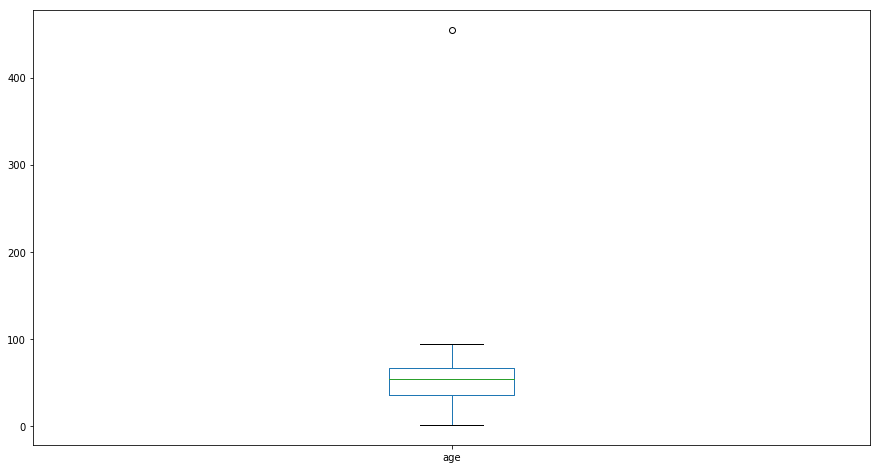

In [14]:
data['age'].plot(kind='box', figsize = (15,8))

In [15]:
data[(pd.isnull(data['age']))]

,age,sex,on antithyroid medication,sick,query hyperthyroid,lithium,goitre,tumor,hypopituitary,TSH,...,I131 treatment,T3 measured,T4U measured,TSH measured,on thyroxine,pregnant,psych,query hypothyroid,query on thyroxine,thyroid surgery
1185,NaN,Female,False,False,False,False,False,False,False,0.6,...,True,True,True,True,True,False,False,False,False,False


Pre výpočet veku by sme mohli použiť atribút date of birth avšak ani v tomto riadku nemáme záznam


In [16]:
data.loc[1185,'date_of_birth']

nan

Chýbajúcu hodnotu sme sa rozhodli nahradiť priemerom, ale keďže išlo o ženu tak priemerom žien.

In [17]:
pd.isna(data['age']).sum()


1

In [18]:
df = data[['age','sex']]
female_mean = df.groupby('sex', as_index=False).age.mean()
data['age'].fillna(round(female_mean.loc[1,'age'],1),inplace = True)
#data.loc[data['age'] == np.nan] = female_mean

Nastavme rovno aj jej dátum narodenia

In [19]:
data.loc[1185,'date_of_birth'] = str(2018 - int(data['age'].iloc[1185])) + "-02-12"
data.loc[1185,'date_of_birth']

'1967-02-12'

Nahradenie vychýlenej MAX hodnoty - mediánom

In [20]:
data[data['age']==455]

,age,sex,on antithyroid medication,sick,query hyperthyroid,lithium,goitre,tumor,hypopituitary,TSH,...,I131 treatment,T3 measured,T4U measured,TSH measured,on thyroxine,pregnant,psych,query hypothyroid,query on thyroxine,thyroid surgery
1285,455.0,Female,False,False,False,False,False,False,False,1.1,...,False,True,True,True,False,False,False,False,False,False


In [21]:
data.loc[1285,'age'] = round(data['age'].median())
data.loc[1285,'age']

54.0

## Attribute TSH, TSH measured

Spojitý atribút nad ktorým môžeme vykonávať deskriptívnu štatistiku. Okrem ineho: TSH je tyreostimulačný hormón, vylučovaný hypofýzou, riadiaci funkciu štítnej žľazy. Koncentrácia TSH v krvi je zvýšená, keď je priamo poškodená štítna žľaza. hodnota TSH je fyziologicky 0,5-5 mIU/l. 

Keďže sme zistili že hypertyreóza(TSH pod normou) 15-násobne častejšie v porovnaní s mužmi postihuje ženy a hodnota TSH u žien sa pohybuje v rozmedzí 0.4-4 mU. Je pravdepodobnejšie, že ak sú hodnoty TSH vyššie jedná sa skôr o ženu ako o muža



Nahradenie chybajúcich hodnôt žien, ženským priemerom hodnoty TSH

In [22]:
df = data[['TSH','sex']]
female_mean = df.groupby('sex', as_index=False).TSH.mean()
data['TSH'].fillna(round(female_mean.loc[1,'TSH'],1),inplace = True)
#data.loc[data['TSH'] == np.nan] = female_mean
pd.isna(data['TSH']).sum()#df = data[['TSH','sex']]
#female_mean = df.groupby('sex', as_index=False).TSH.mean()
#data['age'].fillna(round(female_mean.loc[1,'age'],1),inplace = True)

0

In [23]:
data['TSH measured'].value_counts()

True     2516
False     284
Name: TSH measured, dtype: int64

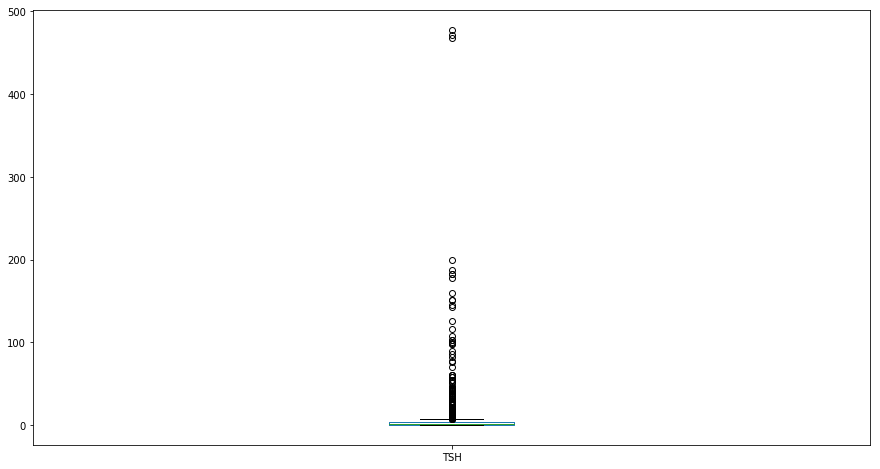

In [24]:
data['TSH'].plot(kind='box', figsize = (15,8))

Data skúsime znormalizovať

Text(0.5,1,'index: 20 (box-cox)')

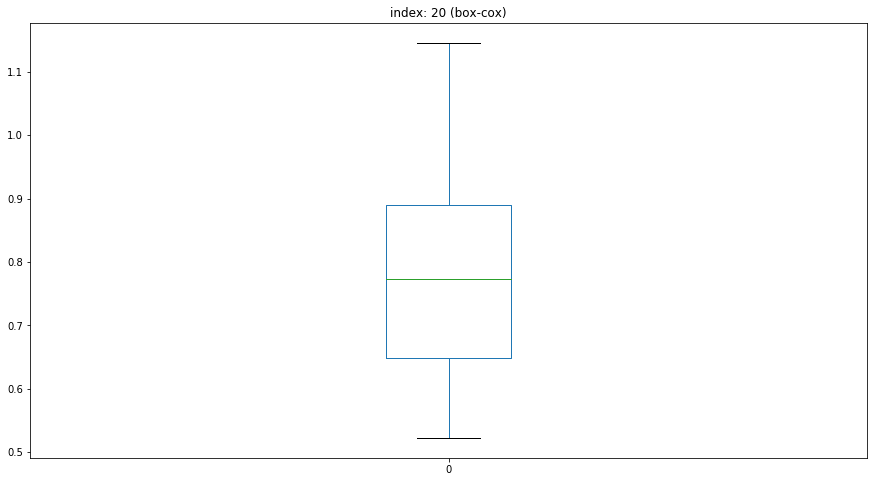

In [25]:
index = 20
transformed, att = stats.boxcox(data['TSH']+2)# boxcox vrati transformovane data a parametre transformacie. Tie viem zafixovat a v tom pripade mi to vrati len transformovane data
pom = pd.DataFrame(transformed).plot(kind='box', figsize = (15,8))
pom.set_title("index: %d (box-cox)" % index)

Box plot nám ukazuje rozloženie dát po normalizácií, ak si pozrieme

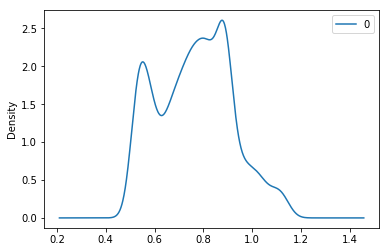

In [26]:
pd.DataFrame(transformed).plot.kde()

Vidíme že dáta sú krajšie (normálnejšie) rozdelené, no stále nie ideálne. 

Keď sme sa pozerali na to, ako TSH ovplyvňuje iné atribúty, resp. ako ovplyvňuje výslednú triedu, zistili sme, že TSH má veľký vplyv, preto sme sa nakoniec rozhodli nechať TSH v pôvodných hodnotách a normalizáciu nerobiť.

## Attribute T3, T3 measured

V atribúte T3 sa nachádza veľa chýbajúcich hodnôt, nakoľko sme našli koreláciu medzi atribútom TT4 a T3, dopĺňame chýbajúce hodnoty lineárnou regresiou.

Background: T3 a TT4 sú hormóny predukované štítnou žľazou. Jeden z druhého sa dajú vyrátať, teda existuje medzi nimi reálny vzťah. Vďaka tejto informácií sme zvolili lineárnu regresiu, ktorá najlepšie napodobnila ten vzťah. Samotný vzťah však závisí ešte od ďalších vecí.

Pridávame aj porovnanie doplnenia chýbajúcich hodnôt priemerom a lineárnou regresiou.

Rozdelenie dát pred zmenou:

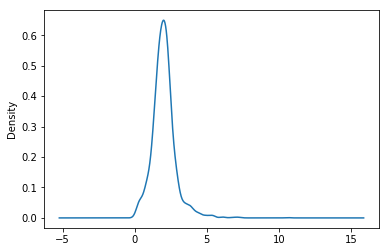

In [27]:
data['T3'].plot(kind='kde')

Rozdelenie dát po nahradení chýbajúcich hodnôt priemerom:

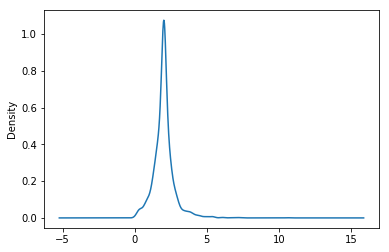

In [28]:
Zaloha = copy.deepcopy(data['T3'])
PomDF = copy.deepcopy(data['T3'])
PomDF.fillna(PomDF.mean(), inplace=True)
PomDF.plot(kind='kde')

### Doplnenie hodnôt pre T3 pomocou lineárnej regresie 

In [29]:
import sklearn
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
df = data[['TT4','T3']]
df.dropna(axis=0, how='any', inplace=True)
X = df['TT4'].reshape(-1,1)
#data['T3'].loc[data['T3'].isna()].drop(axis=0)
#df['TT4'].isna().sum()
lm.fit(X,df['T3'])
data_T3_null = data['TT4'].loc[(data['T3'].isna()) & (~data['TT4'].isna())]
data_T3_null
data['T3'].loc[(data['T3'].isna()) & (~data['TT4'].isna())] = lm.predict(np.array(data_T3_null).reshape(-1,1))

/home/tomasmizera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/tomasmizera/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/home/tomasmizera/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


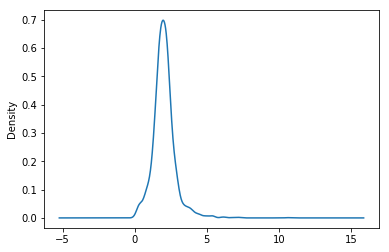

In [30]:
data['T3'].plot(kind='kde')

In [31]:
data['T3'].isna().sum()

158

Ešte stále nám zostáva 158 NaN hodnôt, nakoľko pre tieto hodnoty bolo TT4 takisto NaN, a tieto sme sa rozhodli nahradiť priemerom.

In [32]:
linearRegressionWM = copy.deepcopy(data['T3'])
data['T3'].fillna(data['T3'].mean(),inplace=True)

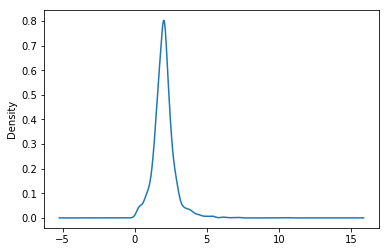

In [33]:
data['T3'].plot(kind='kde')

Detailné porovnanie rozdelenia hodnôt hormónu T3, vidíme že lineárna regresia bez následného pridávania priemeru vyšla ako najlepšia, no zvyšné hodnoty sme museli dosadiť, preto sme zvolili lineárnu regresiu s priemerom (modrú krivku).

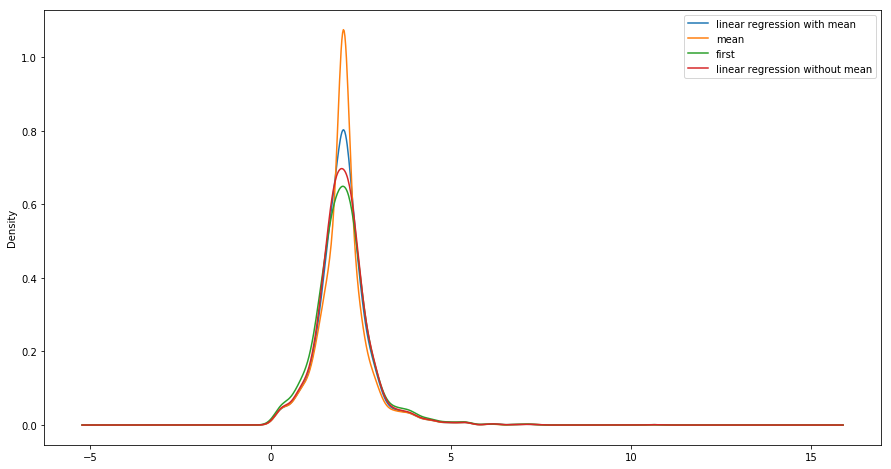

In [34]:
novy_DF = pd.DataFrame()
novy_DF['linear regression with mean'] = data['T3']
novy_DF['mean'] = PomDF
novy_DF['first'] = Zaloha
novy_DF['linear regression without mean'] = linearRegressionWM
novy_DF.plot(kind='kde', figsize = (15,8))

### Attribute TT4

V TT4 máme 184 chýbajúcich hodnôt, ktoré sme sa rozhodli nahradiť mediánom.

In [35]:
data['TT4'].fillna(data['TT4'].median(),inplace=True)

### Attribute T4U, T4U measured

Znova priveľa chýbajúcich hodnôt, nahrádzame mediánom.

In [36]:
data['T4U'].isnull().sum()

297

In [37]:
data[['T4U','T4U measured']].loc[(data['T4U measured'] == True) & (data['T4U'] == np.nan)].count()

T4U             0
T4U measured    0
dtype: int64

In [38]:
data['T4U'].fillna(data['T4U'].median(), inplace = True)

### Attribute FTI, FTI measured

Znova priveľa chýbajúcich hodnôt, no tie neboli ani merané, preto nan nahrádzame iba "undefined". Pre lepšiu zrozumiteľnosť, nahrádzame t/f hodnoty atribútu measured na true/false.

Taktiež, FTI má typ object, kvôli čomu nemôžeme robiť potrebné štatistiky, preto ho prevedieme na numerický typ

In [39]:
data['FTI'] = data['FTI'].astype(float)

In [40]:
data[['FTI','FTI measured']].loc[(data['FTI measured'] == True) & (data['FTI'] == np.nan)].count()

FTI             0
FTI measured    0
dtype: int64

In [41]:
data['FTI'].fillna(data['FTI'].median(), inplace = True)
data['FTI'].head(10)

0    130.0
1    116.0
2    100.0
3     98.0
4     97.0
5    105.0
6    108.0
7     92.0
8    131.0
9    135.0
Name: FTI, dtype: float64

### TBG, TBG measured

TBG nebola meraná ani pri jednom pacientovi, preto tieto 2 atribúty môžme odstrániť

In [42]:
data['TBG measured'].unique()

array([False])

In [43]:
data['TBG'].unique()

array([nan])

In [44]:
data.drop(columns = ['TBG', 'TBG measured'], axis=1, inplace = True)

## Attribute class

Predikovaný atribút class, nemá chýbajúce hodnoty, len jeho hodnoty treba očistiť a zjednotiť.

In [45]:
data['class'].str.startswith('nega').sum()
data[['class']].loc[~((data['class'].str.startswith('negative')) | (data['class'].str.startswith('Negative')))].head(10)

,class
53,underreplacement.|785
68,overreplacement.|1495
126,underreplacement.|3573
140,replacement therapy.|806
157,underreplacement.|1241
166,replacement therapy.|3685
223,underreplacement.|1599
249,replacement therapy.|1016
252,underreplacement.|3562
279,replacement therapy.|3027


In [46]:
data['class'].isnull().sum()

0

In [47]:
classes = data['class'].apply(lambda x: x.partition('.')[0])

classes = classes.str.lower()
data['class'] = classes
data['class'].value_counts()

negative               2713
underreplacement         35
replacement therapy      29
overreplacement          23
Name: class, dtype: int64

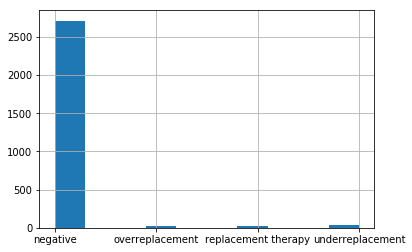

In [48]:
data['class'].hist()

Na klasifikovanie máme teda 4 triedy, z toho trieda "negative" je najpočetnejšia, na zváženie by bolo pri zlých výsledkoch úprava tried na 2 triedy: negative a non-negative (zlúčenie ostatných troch do jednej triedy).

## Attribute education, education-num

Education-num predstavuje ordinalnu hodnotu pre atribut education. Education number treba upraviť, obsahuje chybné hodnoty (napr. hodnoty posunuté o rád - 9, 900, -90,., takéto nahrádzame najmänšou pozitícnou hodnotou, 9 v tomto prípade.), vieme ich opraviť na základe atribútu education.

In [49]:
data['education'] = data['education'].str.replace('-', '_')

In [50]:
data['education'].unique()

array([' Assoc_acdm', ' Assoc_voc', ' Some_college', ' HS_grad',
       ' Bachelors', ' 10th', ' 9th', ' Doctorate', ' 7th_8th', ' 12th',
       ' 11th', ' Masters', ' Prof_school', ' 5th_6th', ' 1st_4th',
       ' Preschool'], dtype=object)

In [51]:
def minimum_positive(cond):
    mi = 11000
    for o in data['education-num'].loc[data['education'] == cond]:
        if (o > 0) & (o < mi):
            mi = o
            
    return mi

dic = {}

for a in data['education'].unique():
    dic[a] = (minimum_positive(a))
    
data['education-num'] = data.education.map(dic)
data['education-num'].head(10)

0    12.0
1    11.0
2    10.0
3     9.0
4    13.0
5     9.0
6    10.0
7    10.0
8     9.0
9    10.0
Name: education-num, dtype: float64

## Attribute workclass a occupation

Požívame KNN pre nahradenie chýbajúcich kategorických dát vo workclass a occupation. V analýze sme zistili že chýbajúce údaje sa nachádzajú v zhodných riadkoch. 

KNN sme vycvičili na atribútoch education-num, age a hours-per-week klasifikovať v akej sfére (workclass) pacient pracuje a aké má povolanie (occupation).

In [52]:
data[['workclass','occupation']].loc[(data['workclass'] == ' ?') & (data['occupation'] == ' ?')].shape[0]

0

In [53]:
data[['workclass', 'occupation', 'education', 'education-num', 'age', 'hours-per-week']].sort_values('education-num').head(15)

,workclass,occupation,education,education-num,age,hours-per-week
1845,Private,Farming-fishing,Preschool,1.0,22.0,36
626,NaN,NaN,Preschool,1.0,69.0,20
789,Private,Other-service,Preschool,1.0,41.0,12
2510,Private,Machine-op-inspct,Preschool,1.0,42.0,40
1105,Private,Machine-op-inspct,Preschool,1.0,70.0,40
2451,Private,Machine-op-inspct,Preschool,1.0,22.0,30
1142,Private,Other-service,Preschool,1.0,33.0,40
1356,Private,Farming-fishing,1st_4th,2.0,59.0,50
777,Private,Other-service,1st_4th,2.0,35.0,35
868,Private,Craft-repair,1st_4th,2.0,62.0,32


In [54]:
data[['workclass', 'occupation']] = data[['workclass', 'occupation']].replace(' ?', np.nan)
data[['workclass', 'occupation']] = data[['workclass', 'occupation']].apply(lambda x: x.str.strip())

In [55]:
from sklearn.neighbors import KNeighborsClassifier

df = data[['education', 'education-num', 'age', 'hours-per-week', 'workclass', 'occupation']]
chopped = df.dropna(axis = 0, how = "any")

X = np.array(chopped.iloc[:, 1:4])
y = np.array(chopped[['workclass', 'occupation']])

example = np.array(df[['education-num', 'age', 'hours-per-week']].iloc[200])
print(example)
#example = example.dropna(axis = 1, how = "any")

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X, y)

prf = knn.predict(example.reshape(1, -1))
prf
#Yeeeees, mame to!! :)

[ 9. 58. 40.]


array([['Private', 'Craft-repair']], dtype=object)

Model máme nacvičený, teraz ho treba použiť :)

In [56]:
#for b in data[['workclass', 'occupation']].loc[data['workclass'].isnull() == True]:
#    print(b)

to_be_filled = data[['education', 'education-num', 'age', 'hours-per-week', 'workclass', 'occupation']].loc[data['workclass'].isnull() == True]

dic_work = {}

#predict = np.array(to_be_filled[:, 1:4])



'''
for inx, item in to_be_filled.iterrows():
    args = np.array(item[['education-num', 'age', 'hours-per-week']])
    a = knn.predict(args.reshape(1, -1))
    dic_work[a[0][0]] = a[0][1]

dic_work
'''

#data[['workclass', 'occupation']]
#predict
to_be_filled.iloc[:, 1:4]
predicted = knn.predict(np.array(to_be_filled.iloc[:, 1:4]))

In [57]:
df_predicted = pd.DataFrame(predicted)

for i, row in df.iterrows():
  ifor_val = something
  if <condition>:
    ifor_val = something_else
  df.set_value(i,'ifor',ifor_val)

In [58]:
df_predicted
for inx, row in data[['workclass', 'occupation']].iterrows():
    pass

## PLS HELP!! :( :(

In [59]:
data['workclass'].loc[data['workclass'].isnull() == True] = df_predicted[0].values


/home/tomasmizera/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [60]:
data['occupation'].loc[data['occupation'].isnull() == True] = df_predicted[1].values

/home/tomasmizera/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [61]:
data['occupation'].isnull().sum()

0

## Attribute fnlwgt

Atribút fnlwgt sme sa rozhodli normalizovať nakoľko nekoreluje s inými hodnotami. Chceme nájsť jeho vychýlené hodnoty. Použijeme preto boxcox pre normalizáciu.

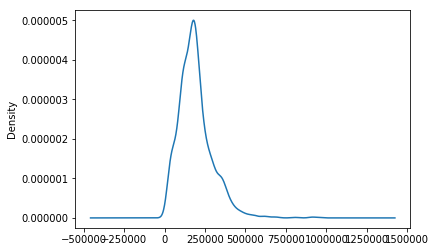

In [62]:
data['fnlwgt'].plot.kde()

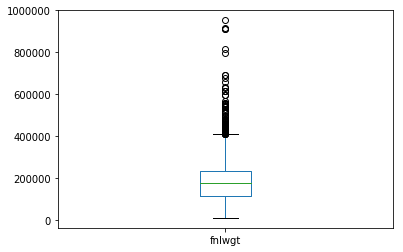

In [63]:
data['fnlwgt'].plot.box()

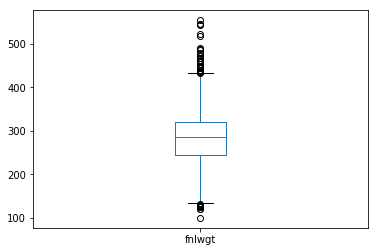

In [64]:
#data['fnlwgt'] = stats.boxcox(data['fnlwgt'])
transformed = pd.DataFrame()
index = 20
transformed['fnlwgt'], att = stats.boxcox(data['fnlwgt']+2)

data['fnlwgt'] = transformed['fnlwgt']
pom = pd.Series(transformed['fnlwgt']).plot.box()

Vidíme že stále zostávajú nejaké vychýlené hodnoty, no tieto nebudeme odstraňovať, pretože fnlwgt predstavuje určitý pomer hormónov a mohlo by ovplyvniť výslednú klasifikáciu.

## Attribute native-country

46 záznamov nemá vyplnené native country - vytvorili sme novú triedu "Unknown"

In [65]:
data[data['native-country'].isna()]
data['native-country'].isna().value_counts()

False    2754
True       46
Name: native-country, dtype: int64

In [66]:
data['native-country'].fillna("Unknown", inplace=True)
data['native-country'].isna().sum()

0

In [67]:
data['native-country'].unique()

array([' United-States', ' Cuba', ' Peru', ' Cambodia',
       ' Dominican-Republic', ' Vietnam', ' Japan', ' Ecuador', ' Haiti',
       'Unknown', ' South', ' El-Salvador', ' India', ' Canada',
       ' Mexico', ' Jamaica', ' China', ' Thailand', ' Columbia',
       ' Italy', ' Philippines', ' Guatemala', ' Scotland',
       ' Puerto-Rico', ' Germany', ' England', ' Portugal', ' Poland',
       ' Taiwan', ' Iran', ' France', ' Greece', ' Holand-Netherlands',
       ' Nicaragua', ' Outlying-US(Guam-USVI-etc)', ' Ireland',
       ' Hungary'], dtype=object)

In [68]:
eu_countries = ["Hungary","Poland","Ireland","France","England","Portugal","Germany","Italy","Holand-Netherlands","Greece"]

def translate(country):
    if country in eu_countries:
        country = "Europe"
    elif country == "Unknown country":
        return country
    elif country != "United-States":
        country = "Other"
    return country

In [69]:
data.rename(columns={'native-country': 'native_country'}, inplace=True)
data[['native_country']] = data[['native_country']].apply(lambda x: x.str.strip())
data['native_country'] = data['native_country'].map(translate)



## Attribute date_of_birth

Dátumy majú rôzny formát- je potrebné ho upraviť

In [70]:
def correct_date_format(date):
    date = str(date).replace('/', '-')
    date = date[:10]
    return date 
    

In [71]:
data['date_of_birth'] = data['date_of_birth'].map(correct_date_format)
#data['date_of_birth'] = pd.to_datetime(data['date_of_birth'], format = '%Y-%m-%d %H:%M:%S')
#data['date_of_birth'] = data['date_of_birth'].dt.strftime('%m/%d/%Y')


In [72]:
def date(text):
    year = text.split("-")
    if year[0] != 'nan':
        if len(year[0]) != 4:
            if len(year[2]) == 2 and int(year[0]) > 31:
                new_date = "19"+year[0]+"-"+year[1]+"-"+year[2] 
            elif len(year[2]) == 2 and int(year[0]) < 31 and int(year[2]) > 31:
                new_date = "19"+year[2]+"-"+year[1]+"-"+year[0] 
            else:
                new_date = year[2]+"-"+year[1]+"-"+year[0] 
            return new_date
    return text

In [73]:
data['date_of_birth'] = data['date_of_birth'].map(date)

Chceli sme skontrolovať, či sedí vek pacientov podľa ich dátumu narodenia avšak zistili sme, že dáta, ktoré máme k dispozícii boli pravdepodobné merané v dvoch až viacerých rokoch a preto by sme dáta nevedeli vhodne upraviť, pretože nevieme či boli merané v roku 2018 alebo 2017 a pod.

In [74]:
def check_age(row):
    new = row['date_of_birth'].split("-")
    #print(new[0])
    age = 2017 - int(new[0])
    if row['age'] != age:
        #print("Nezhoda", row['age'], age)
        new_age = 2018 - int(age)
        return new_age
    return row['age']

In [75]:
for i, row in data.iterrows():
    check_age(row)

## Attribute query hypothyroid

Zopár chýbajúcich hodnôt, pridávame triedu unknown.

In [76]:
data['query hypothyroid'].fillna('Unknown',inplace=True)
data['query hypothyroid'].unique()

array([False, 'Unknown', True], dtype=object)

# Bivariate analýza a hľadanie korelácií

Doplnková bivariant analýza pre atribúty, hľadáme korelácie a zároveň si na grafoch môžme všímať ako hodnota niektorých atribútov ovplyvňuje výslednú triedu.

Tieto seaborn ploty trvajú chvíľu dlhšie pokiaľ sa vygenerujú.

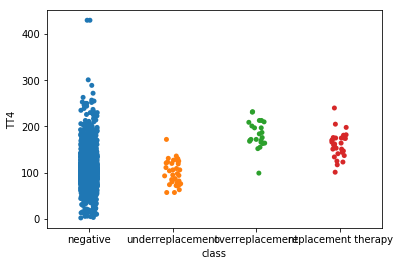

In [77]:
seaborn.stripplot(x="class", y="TT4", data=data,  jitter=True);

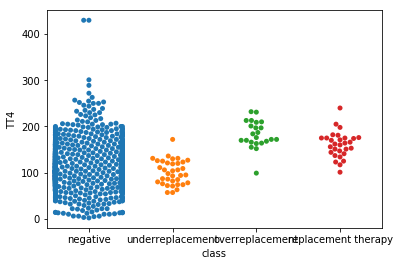

In [78]:
seaborn.swarmplot(x="class", y="TT4", data=data);

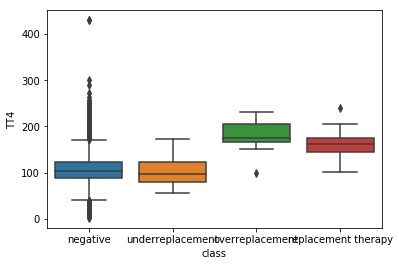

In [79]:
seaborn.boxplot(x="class", y="TT4", data=data)

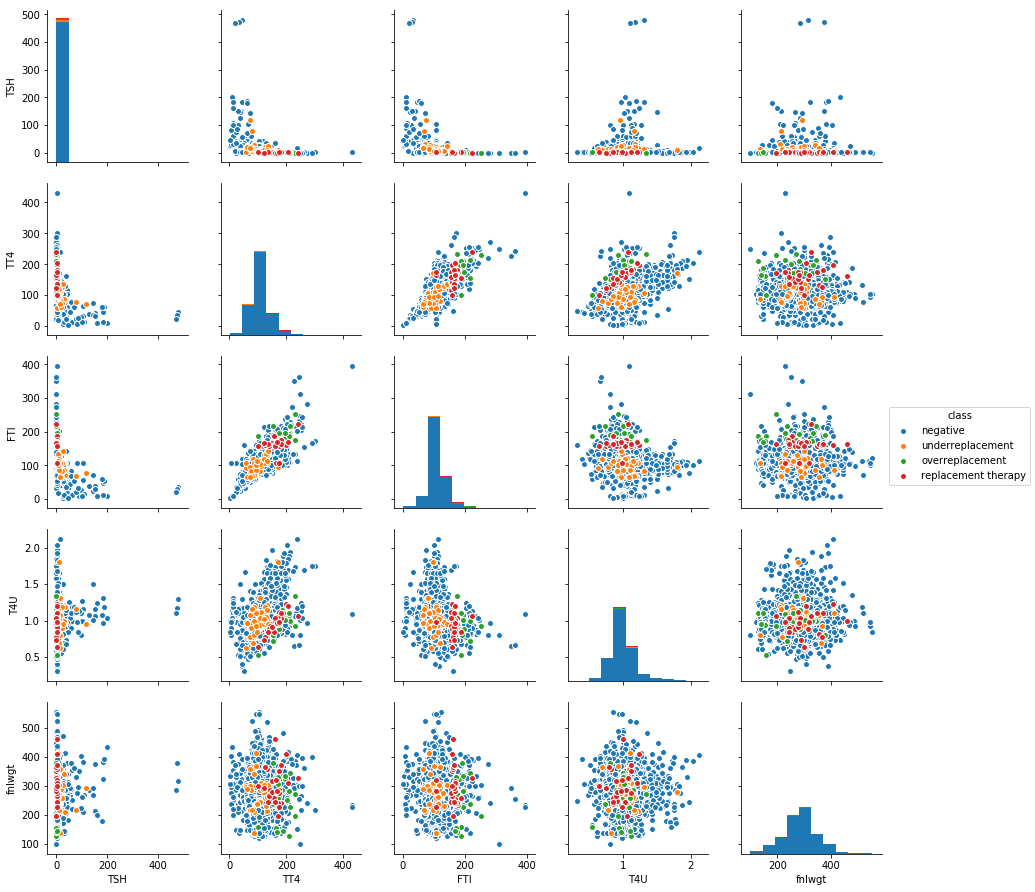

In [80]:
#li = []
#li.append(data['class'].unique())
data['FTI'] = data['FTI'].astype(float)
seaborn.pairplot(data[['TSH','TT4', 'FTI','T4U','fnlwgt','class']],dropna=True, hue='class')

Najmä z týchto pairplot grafov sme dostali naše klasifikačné pravidlá.

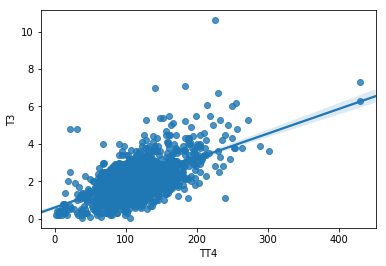

In [81]:
seaborn.regplot(x="TT4", y="T3", data=data);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe7565c7400>,
      dtype=object)

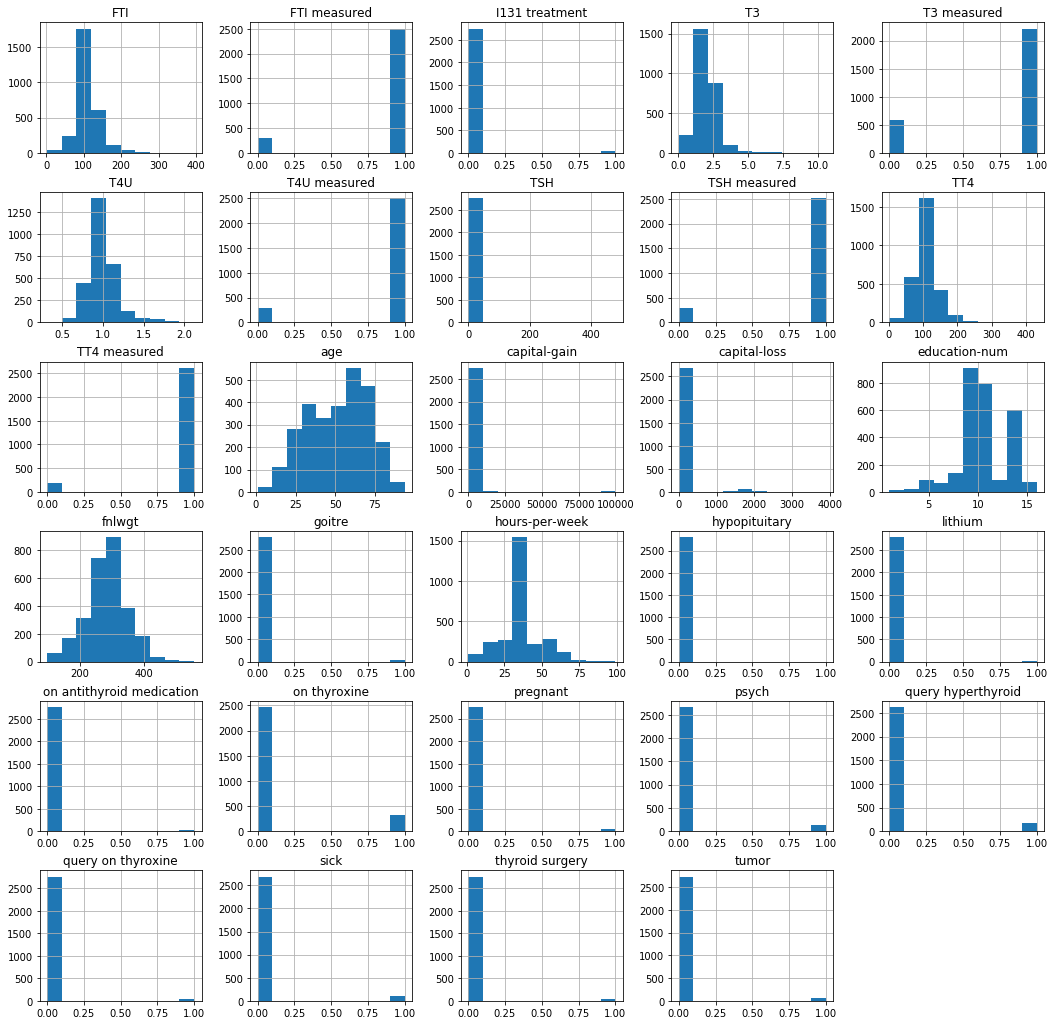

In [82]:
data.hist(figsize=(18, 18))

### Hľadáme korelácie na základe data.corr() pomocou heatmapy

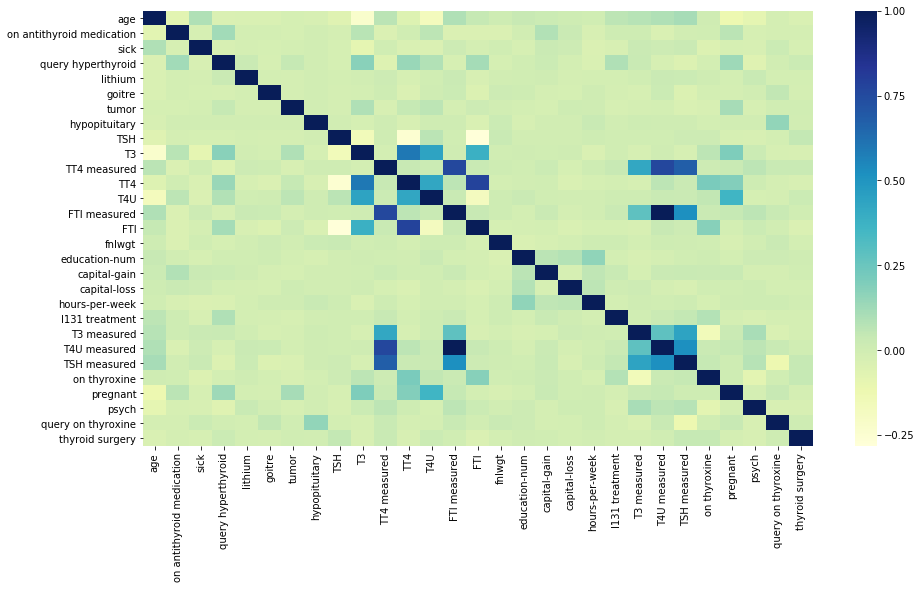

In [83]:
corr = data.corr()
plt.subplots(figsize=(15,8))
seaborn.heatmap(corr, cmap="YlGnBu",xticklabels=corr.columns, yticklabels=corr.columns)

Na Heatmape sme našli korelácie viacerých atribútov, hlavne:
 * Korelácie, keď boli merané hodnoty FTI, boli merané aj hodnoty T4U, TSH a TT4
 * Následne aj korelácia hodnôt T3 a TT4 (preto sme robili regresiu)
 * TT4 koreluje s T4U okolo hodnoty 0.5
 * Môžme vidieť aj koreláciu hodnôt TT4 a FTI
 * Slabšiu koreláciu vidno aj medzi T3 a FTI, prip. T4U

#### Hľadali sme aj korelácie medzi kategorickými hodnotami atribútmi vzhľadom na predikovanú triedu, no nenašli sme žiadne viditeľné znaky, napríklad: 

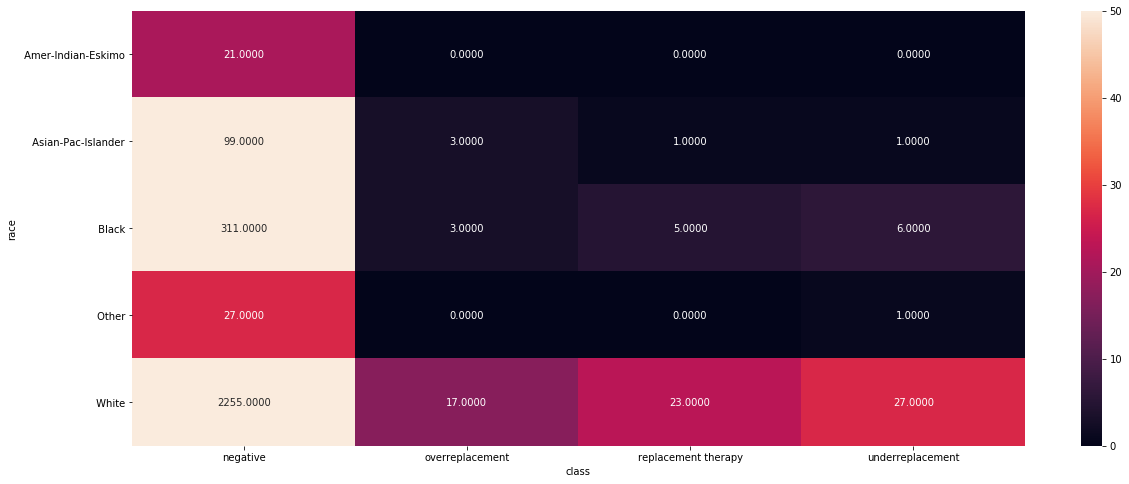

In [84]:
table = pd.crosstab(index = data['race'], columns = data['class'])


plt.subplots(figsize=(20,8))
seaborn.heatmap(table, vmax = 50, annot = True, fmt = ".4f")

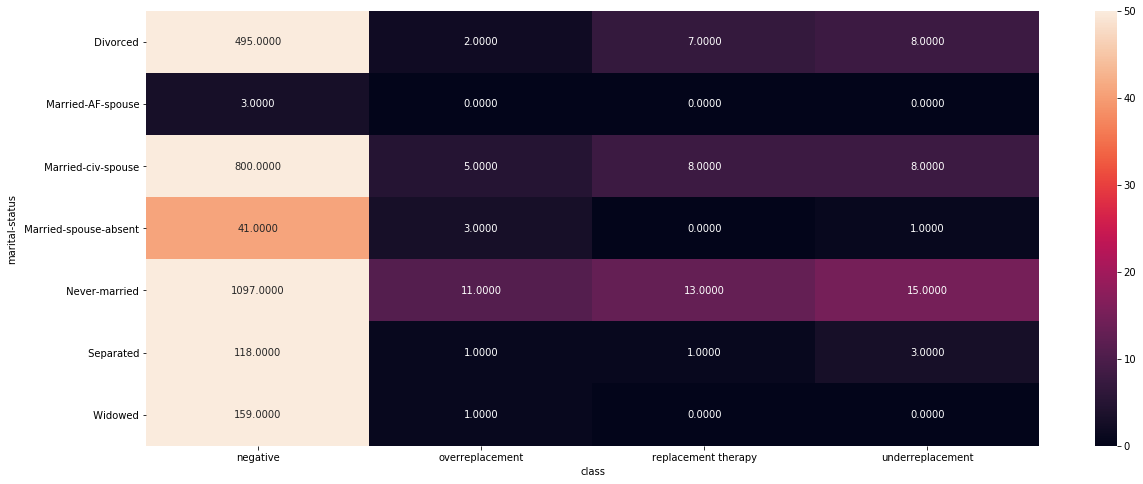

In [85]:
table = pd.crosstab(index = data['marital-status'], columns = data['class'])


plt.subplots(figsize=(20,8))
seaborn.heatmap(table, vmax = 50, annot = True, fmt = ".4f")

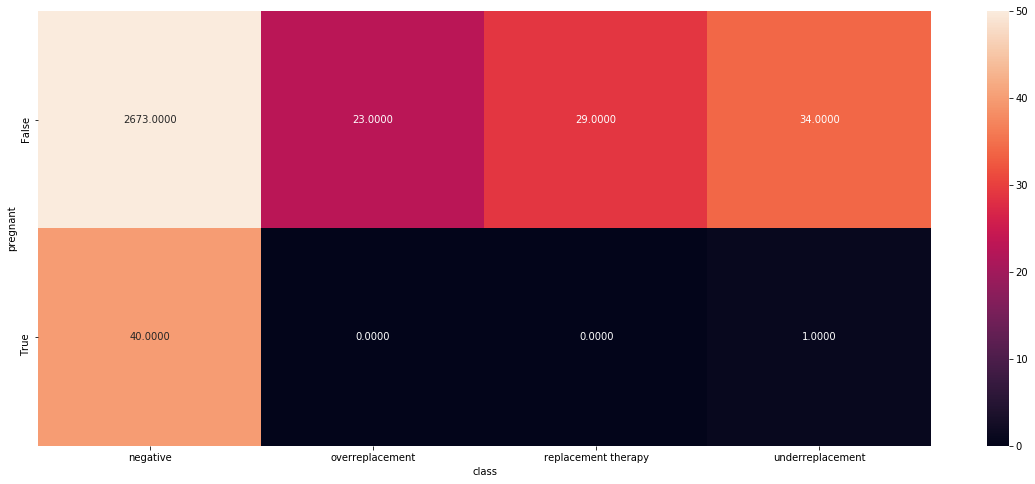

In [86]:
table = pd.crosstab(index = data['pregnant'], columns = data['class'])


plt.subplots(figsize=(20,8))
seaborn.heatmap(table, vmax = 50, annot = True, fmt = ".4f")

## Na základe takto získaných informácií sme sa snažili nájsť klasifikačné pravidlá 

### Pravidlo #1: 
#### ak je hodnota FTI pod hodnotu 65, pacient bude patriť do triedy negative

In [87]:
data['class'].loc[data['class'] == 'negative'].count()

2713

In [88]:
data['class'].loc[data['FTI'] < 65].value_counts() 

negative    90
Name: class, dtype: int64

In [89]:
data['class'].loc[data['FTI'] > 64].value_counts()

negative               2623
underreplacement         35
replacement therapy      29
overreplacement          23
Name: class, dtype: int64

![alt text](./data/rule_01.png "1. pravidlo klasifikacie")

**accuracy**: TP + TN / total population = (90 + 87) / 2800 = __0.06__

**precision**: TP / FP + TP = __1__

**recall**: TP / FN + TP = __0.03__

------------------------------

### Pravidlo #2: 
#### hodnota TT4 v intervale 50 až 300 a T4U v intervale 0.5 až 1.5 pacient je nachylny na chorobu

Viac rozmerne pravidlo, preto by zrejme mohlo byt presnejsie

In [90]:
data['class'].loc[((data['TT4'] < 300) & (data['TT4'] > 50)) & ((data['T4U'] > 0.5) & (data['T4U'] < 1.5))].value_counts()

negative               2571
underreplacement         34
replacement therapy      29
overreplacement          23
Name: class, dtype: int64

In [91]:
data['class'].loc[data['class'] == 'negative'].count() - 2571

142

In [92]:
data['class'].loc[data['class'] != 'negative'].count() - 86

1

![alt text](./data/rule_02.png "2. pravidlo klasifikacie")

**accuracy**: TP + TN / total population = __0.08__

**precision**: TP / FP + TP = __0.03__

**recall**: TP / FN + TP = __0.98__

--------------------------------------------

### Pravidlo #3: 
#### hodnota TT4 v intervale 100 až 200, pacient patrí do triedy replacement therapy

In [93]:
data['class'].value_counts()

negative               2713
underreplacement         35
replacement therapy      29
overreplacement          23
Name: class, dtype: int64

In [94]:
data['class'].loc[(data['TT4'] > 100) & (data['TT4'] < 200)].value_counts()

negative               1543
replacement therapy      27
underreplacement         17
overreplacement          15
Name: class, dtype: int64

In [95]:
data['class'].loc[~((data['TT4'] > 100) & (data['TT4'] < 200))].value_counts()

negative               1170
underreplacement         18
overreplacement           8
replacement therapy       2
Name: class, dtype: int64

![alt text](./data/rule_03.png "3. pravidlo klasifikacie")

**accuracy**: TP + TN / total population = __0.43__

**precision**: TP / FP + TP = __0.01__

**recall**: TP / FN + TP = __0.93__

---------------------------------------------

### Pravidlo #4:
#### ak je hodnota T4U > 1.5, pacient patrí do triedy negative 

In [96]:
data['class'].loc[data['T4U'] > 1.5].value_counts()

negative            66
underreplacement     1
Name: class, dtype: int64

In [97]:
data['class'].loc[data['T4U'] <= 1.5].value_counts()

negative               2647
underreplacement         34
replacement therapy      29
overreplacement          23
Name: class, dtype: int64

![alt text](./data/rule_04.png "4. pravidlo klasifikacie")

**accuracy**: TP + TN / total population = __0.05 __  

**precision**: TP / FP + TP = __0.98 __

**recall**: TP / FN + TP = __0.02__

-------------------------------------

# Zhodnotenie

Predspracovanie sme vykonali na všetkých atribútoch, ktoré obsahovali chybné, nekonzistentné, chýbajúce alebo inak na klasifikáciu nevhodné údaje. Pre doplnenie chýbajúcich hodnôt sme využili viacero metód, hlavne: lineárnu regresiu, KNN, ale aj nahradenie chýbajúcich hodnôt priemerom či mediánom. Taktiež sme skúšali chýbajúce údaje odstraňovať, no to malo za následok stratu priveľa dát.

Odstránili sme však atribúty, ktoré nám nedávali žiadne údaje, napríklad atribút, ktorý obsahoval iba false na každom riadku, príp. atribút kde bolo iba jedno true.

Nenormálove rozdelenia sme normalizovali boxcox-om v prípade dvoch atribútov(TSH, fnlwgt), no pri jednom z nich (TSH) sa ukázalo že jeho hodnota má veľký dopad na výslednú triedu, preto sme zmeny radšej vrátili a nechali pôvodné dáta. Spoliehame sa pri tomto rozhodnutí na fakt, že v ďalšej fáze sa rozhodovací strom vie naučiť klasifikovať aj na nenormalizovaných dátach. Videli sme to už aj v tejto časti projektu, lineárna regresia sa pekne naučila predikovať hodnoty aj na nenormalizovaných atribútoch (T3, TT4).

Pri nájdených klasifikačných pravidlách si uvedomujeme ich nedostatok, žiaľ, na našej vzorke dát sme neboli schopní nájsť pravidlá, ktoré by dávali lepšiu *accuracy*, *precision*, prip. *recall*. Do ďalšieho odovzdania veríme, že strom dokáže vytvoriť lepšie pravidlá ako naše nájdené. Pri jednom z pravidiel sme síce získlali accuracy okolo 43%, no precision a recall boli veľmi veľké, resp. veľmi malé.

Pridali sme do tohoto odovzdania aj bivariate analýzu, aby sme vedeli lepšie nájsť atribúty, ktoré korelujú. Podarilo sa a vďaka tomu sme vedeli spustiť lineárnu regresiu.

Do ďalšieho odovzdania chceme toto predspracovanie upraviť tak, aby sme na ňom vedeli bez problémov spustiť testovacie dáta, resp. bez toho aby sme *trénovali na testovacích* dátach.

Na koniec pridávame ešte analýzu hlavných zmenených atribútov. 

-------------------------

# Opätovná analýza hlavných zmenených atribútov

#### Počet stĺpcov
Počet stĺpcov sa zmenil, zahodili sme tie, ktoré nám nedávali informácie

In [98]:
data.shape[1]

41

Počet riadkov však zostal zachovaný, vážime si dáta, aj tak ich máme málo

In [99]:
data.shape[0]

2800

#### Po novom, nemáme chýbajúce hodnoty

In [100]:
data.shape[0] - data.dropna().shape[0]

0

### Porovnanie deskriptívnych štatistík numerických atribútov pred a po spracovaní

In [101]:
default_data.replace(['f','F','FALSE','false','t','true','TRUE','T','?', ' ?','??','nan'], [False,False, False,False,True,True,True,True,np.nan, np.nan, np.nan, np.nan], inplace = True)
default_data['FTI'] = default_data['FTI'].astype(float)
default_data.drop(columns = ['TBG', 'TBG measured'], axis=1, inplace = True)
default_data.describe()

,age,TSH,T3,TT4,T4U,FTI,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,2799.00000,2516.000000,2215.000000,2616.000000,2503.000000,2505.000000,2800.000000,2520.000000,2800.000000,2800.000000,2800.000000
mean,51.84423,4.672150,2.024966,109.072401,0.997912,110.787984,190504.983929,12.480159,863.588571,75.293571,38.138929
std,20.46116,21.449453,0.824600,35.392443,0.194390,32.883986,105060.681231,333.490115,6652.419837,375.638986,12.385913
min,1.00000,0.005000,0.050000,2.000000,0.310000,2.000000,12285.000000,-1600.000000,0.000000,0.000000,1.000000
25%,36.00000,0.440000,1.600000,88.000000,0.880000,93.000000,118945.500000,9.000000,0.000000,0.000000,35.000000
50%,54.00000,1.400000,2.000000,104.000000,0.980000,107.000000,176462.000000,10.000000,0.000000,0.000000,40.000000
75%,67.00000,2.600000,2.400000,125.000000,1.080000,124.000000,235912.750000,13.000000,0.000000,0.000000,40.000000
max,455.00000,478.000000,10.600000,430.000000,2.120000,395.000000,953588.000000,1600.000000,99999.000000,3900.000000,99.000000


In [102]:
data.describe()

,age,TSH,T3,TT4,T4U,FTI,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000,2800.000000
mean,51.700964,4.553261,2.034020,108.739071,0.996012,110.388893,283.875164,10.101786,863.588571,75.293571,38.138929
std,18.984779,20.335252,0.755815,34.232448,0.183871,31.124591,63.456011,2.485110,6652.419837,375.638986,12.385913
min,1.000000,0.005000,0.050000,2.000000,0.310000,2.000000,99.110940,1.000000,0.000000,0.000000,1.000000
25%,36.000000,0.597500,1.622818,89.000000,0.890000,95.000000,244.502561,9.000000,0.000000,0.000000,35.000000
50%,54.000000,1.600000,2.000000,104.000000,0.980000,107.000000,285.714962,10.000000,0.000000,0.000000,40.000000
75%,67.000000,3.500000,2.300000,123.000000,1.070000,122.000000,320.384155,12.000000,0.000000,0.000000,40.000000
max,94.000000,478.000000,10.600000,430.000000,2.120000,395.000000,555.122971,16.000000,99999.000000,3900.000000,99.000000


### Zobrazme si to krajšie, na heatmape

In [103]:
def mean_difference(col_index):
    return (round(default_data[col_index].mean(),2) - round(data[col_index].mean(), 2))

In [104]:
means = {}
num_cols = data.select_dtypes([np.number]).columns

for i in num_cols:
    means[i] = mean_difference(i)

In [105]:
mean_vals = pd.DataFrame(means, index = ['Means difference'])

#### Porovnávame zmenu priemeru numerických atribútov pred a po spracovaní

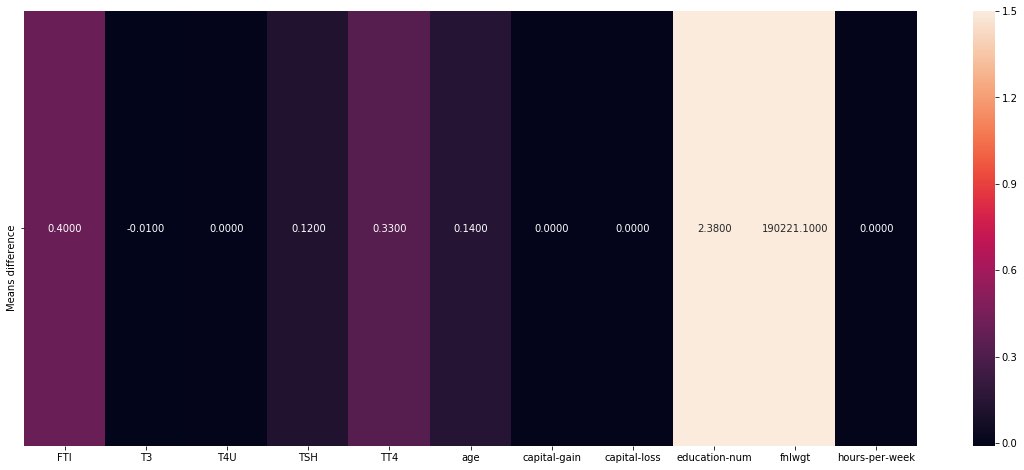

In [106]:
plt.subplots(figsize=(20,8))
seaborn.heatmap(mean_vals, vmax = 1.5, annot = True, fmt = ".4f")

Na heatmape vidíme zmeny priemeru jednotlivých atribútov. Najväčšia zmena nastala pri atribúte fnlwgt, čo dáva zmysel, nokoľko tento bol normalizovaný. Tiež väčšia zmena pri education-num, tu sme opravovali dáta a menili sme hodnoty na čísla rovnakého rádu.

Dobrá správa je, že pri T3 sme používali lineárnu regresiu a zmena priemeru je len minimálna.
Pri FTI a TT4 sme chýbajúce hodnoty nahrádzali priemerom/mediánom, preto je tu zmena opodstatnená.

### Analýza doplnenia kategorických atribútov workclass a occupation pomocou KNN

Workclass a occupation sme predikovali pomocou KNN, na základe hodnôt atribútov hours-per-week, education-num a age (samozrejme už museli byť všetky doplnené), nakoľko predpokladáme, že najmä na základe týchto troch atribútov vieme najlepšie určiť pracovné zaradenie človeka.

Hodnoty pred KNN:

In [107]:
default_data['workclass'].value_counts()

 Private             1981
 Local-gov            209
 Self-emp-not-inc     154
 State-gov            124
 Federal-gov           78
 Self-emp-inc          69
 Without-pay            2
Name: workclass, dtype: int64

Hodnoty po KNN:

In [108]:
data['workclass'].value_counts()

Private             2157
Local-gov            212
Self-emp-not-inc     156
State-gov            124
Federal-gov           80
Self-emp-inc          69
Without-pay            2
Name: workclass, dtype: int64

#### Koľko sme čoho doplnili:

In [109]:
def_cnts = default_data['workclass'].value_counts().tolist()
chng_cnts = data['workclass'].value_counts().tolist()

sol = []
for i in range(len(def_cnts)):
    sol.append(chng_cnts[i] - def_cnts[i])
    
df_sol = pd.DataFrame(sol, index = data['workclass'].value_counts().index.tolist())
df_sol = df_sol.transpose()

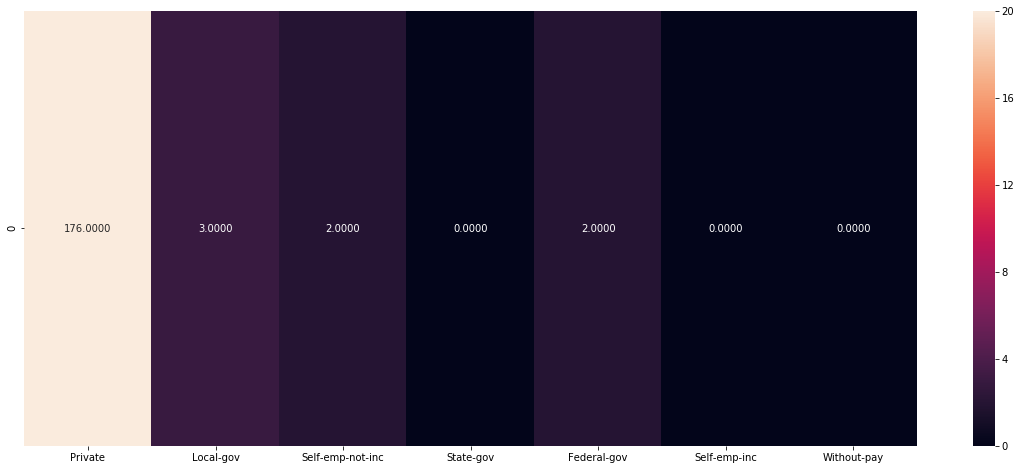

In [110]:
plt.subplots(figsize=(20,8))
seaborn.heatmap(df_sol, vmax = 20, annot = True, fmt = ".4f")

Po použití KNN vieme skonštatovať, že najviac doplnená pracovná skupina bola práve 'Private', čo sa dalo aj predpokladať, nakoľko predstavuje majoritnú skupinu aj v pôvodných dátach.